# Channel Combination Performance Matrix (Recording-wise)

This notebook generates heatmap visualizations comparing sleep staging performance
across different EEG/EOG channel combinations for AnySleep vs U-Sleep models.

## Purpose

Analyze how the choice of input channels affects model performance by computing
macro F1 scores for every pair of channels from a standardized set. This helps
answer questions like:
- Which channel combinations yield the best performance?
- Does AnySleep outperform U-Sleep for specific channel pairs?
- Are certain channels (e.g., central EEG) more informative than others?

## Method

1. **Load confusion matrices** from prediction sweeps
   - exp002a (AnySleep): Attention-based model with variable channels
   - exp001a (U-Sleep): Standard 2-channel model

2. **Standardize channel names** across datasets
   - Rename dataset-specific names to common format (e.g., E1 → EOG1, C3-M2 → C3)
   - Remove bipolar montage channels (containing "-")

3. **Filter recordings** to those with all required channels:
   - EOG (EOG1 or EOG2)
   - Frontal: F3, F4
   - Central: C3, C4
   - Occipital: O1, O2

4. **Compute per-recording macro F1** from confusion matrices
   - Average across all recordings and model seeds

5. **Generate 7×7 heatmaps** showing F1 for each channel pair
   - Perform t-tests comparing AnySleep vs U-Sleep

## Output

- `2_channel_comb_matrix.svg`: Side-by-side heatmaps for both models
- Statistical significance matrix (p-values from Welch's t-test)

## Data Requirements

- Confusion matrix files from `predict-confusion-matrix.py` sweeps
- Log files containing model paths and channel configuration

# Prepare Exp002 (AnySleep) data

In [1]:
import glob
import re

import numpy as np

run_folders_exp002a_att = "../../logs/exp002/exp002a/sweep-2025-07-28_20-33-22_confusion_matrix"

combined_cms_exp002a = {}
for run_file in glob.glob(run_folders_exp002a_att + "/*/pred_cms.npz"):
    run_log = f"{run_file.replace('pred_cms.npz', 'predict-cm.log')}"
    model_line = [l for l in open(run_log).readlines() if "model.path" in l][0]
    n_eeg_line = [l for l in open(run_log).readlines() if "n_eeg_channels" in l][0]
    n_eog_line = [l for l in open(run_log).readlines() if "n_eog_channels" in l][0]
    model = model_line.split("=")[1].strip()
    n_eeg = int(n_eeg_line.split("=")[1].strip())
    n_eog = int(n_eog_line.split("=")[1].strip())
    if n_eog + n_eeg > 2:
        print(f"Skipping {run_file}, n_eeg={n_eeg}, n_eog={n_eog}")
        continue

    if model not in combined_cms_exp002a:
        combined_cms_exp002a[model] = {}
    n_before = len(combined_cms_exp002a[model])
    data = np.load(run_file)
    combined_cms_exp002a[model].update(data)
    print(f"Added {len(combined_cms_exp002a[model]) - n_before}/{len(data)} CMs from {run_file}")
print(len(combined_cms_exp002a[model]))

Skipping ../../logs/exp002/exp002a/sweep-2025-07-28_20-33-22_jannik_cm/17/pred_cms.npz, n_eeg=2, n_eog=2
Skipping ../../logs/exp002/exp002a/sweep-2025-07-28_20-33-22_jannik_cm/14/pred_cms.npz, n_eeg=1, n_eog=2
Added 2553/2553 CMs from ../../logs/exp002/exp002a/sweep-2025-07-28_20-33-22_jannik_cm/10/pred_cms.npz
Added 32401/32401 CMs from ../../logs/exp002/exp002a/sweep-2025-07-28_20-33-22_jannik_cm/24/pred_cms.npz
Added 1462/1462 CMs from ../../logs/exp002/exp002a/sweep-2025-07-28_20-33-22_jannik_cm/20/pred_cms.npz
Skipping ../../logs/exp002/exp002a/sweep-2025-07-28_20-33-22_jannik_cm/16/pred_cms.npz, n_eeg=2, n_eog=1
Added 2422/2553 CMs from ../../logs/exp002/exp002a/sweep-2025-07-28_20-33-22_jannik_cm/19/pred_cms.npz
Added 32401/32401 CMs from ../../logs/exp002/exp002a/sweep-2025-07-28_20-33-22_jannik_cm/15/pred_cms.npz
Added 14316/14316 CMs from ../../logs/exp002/exp002a/sweep-2025-07-28_20-33-22_jannik_cm/31/pred_cms.npz
Added 32401/32401 CMs from ../../logs/exp002/exp002a/sweep-20

In [2]:
ch_rename_dict = {
    "E1(-.*)?": "EOG1\g<1>",
    "E2(-.*)?": "EOG2\g<1>",
    "(.*)-LER": "\g<1>-CLE",
    "EOG\((.)\)-PG1": "EOG(\g<1>)",
    "EOG\(L\)": "EOG1",
    "EOG\(R\)": "EOG2",
    "LOC-A2": "EOG1",
    "ROC-A1": "EOG2",
    "(.*)-A1": "\g<1>-M1",
    "(.*)-A2": "\g<1>-M2",
    "(.*)-M1": "\g<1>",
    "(.*)-M2": "\g<1>",
    "(.*)-CLE": "\g<1>",
}

new_combined_cms_exp002a = {}
for model in combined_cms_exp002a.keys():
    new_combined_cms_exp002a[model] = {}

    for key in combined_cms_exp002a[model].keys():
        chs = key.split("#")[2].split("&")
        # rename
        ren_chs = []
        for ch in chs:
            for k, v in ch_rename_dict.items():
                ch = re.sub(k, v, ch)
            ren_chs.append(ch)
        # remove bipolar channels
        if any("-" in ch for ch in ren_chs):
            continue

        new_key = f"{key.split('#')[0]}#{key.split('#')[1]}#{'&'.join(sorted(ren_chs))}"
        new_combined_cms_exp002a[model][new_key] = combined_cms_exp002a[model][key]

In [3]:
req_channels = ["EOG\\d", "F3", "F4", "C3", "C4", "O1", "O2"]
ds_ch_comb_mat_exp002a = {}

for model in new_combined_cms_exp002a.keys():
    ds_ch_comb_mat_exp002a[model] = [[[] for _ in range(len(req_channels))] for _ in
                                     range(len(req_channels))]

    datasets = set(k.split("#")[0] for k in new_combined_cms_exp002a[model].keys())
    for dataset in sorted(datasets):
        ds_count = 0

        recs = set(k.split("#")[1] for k in new_combined_cms_exp002a[model].keys() if k.startswith(f"{dataset}#"))
        for rec in recs:
            chs = set(
                k.split("#")[2] for k in new_combined_cms_exp002a[model].keys() if k.startswith(f"{dataset}#{rec}#"))
            chs = set(np.concat([c.split("&") for c in chs]))
            if all(any(re.match(rq_ch, ch) for ch in chs)
                   for rq_ch in req_channels):
                ds_count += 1
                for cc_key in filter(lambda key: key.startswith(f"{dataset}#{rec}#"),
                                     new_combined_cms_exp002a[model].keys()):
                    chs_k = cc_key.split("#")[2].split("&")
                    ch_idcs = sorted([i for ch in chs_k for i, ch_name in enumerate(req_channels)
                                      if re.match(ch_name, ch)])
                    if len(ch_idcs) != len(chs_k):
                        continue
                    if len(ch_idcs) == 1:
                        ch_idcs = ch_idcs * 2  # AnySleep evaluates single channels as is instead of duplicating it like USleep does
                    ds_ch_comb_mat_exp002a[model][ch_idcs[0]][ch_idcs[1]].append(
                        new_combined_cms_exp002a[model][cc_key])
        print(dataset, f"{ds_count}/{len(recs)}")

abc 20/20
ccshs 0/78
cfs 0/92
chat 128/128
dcsm 39/39
dodh 0/25
dodo 0/55
hpap 36/36
isruc-sg1 99/100
isruc-sg2 16/16
isruc-sg3 10/10
mass-c1 53/53
mass-c3 62/62
mesa 0/100
mros 0/134
phys 100/100
sedf-sc 0/23
sedf-st 0/8
shhs 0/140
sof 0/68
svuh 0/25
abc 20/20
ccshs 0/78
cfs 0/92
chat 128/128
dcsm 39/39
dodh 0/25
dodo 0/55
hpap 36/36
isruc-sg1 99/100
isruc-sg2 16/16
isruc-sg3 10/10
mass-c1 53/53
mass-c3 62/62
mesa 0/100
mros 0/134
phys 100/100
sedf-sc 0/23
sedf-st 0/8
shhs 0/140
sof 0/68
svuh 0/25
abc 20/20
ccshs 0/78
cfs 0/92
chat 128/128
dcsm 39/39
dodh 0/25
dodo 0/55
hpap 36/36
isruc-sg1 99/100
isruc-sg2 16/16
isruc-sg3 10/10
mass-c1 53/53
mass-c3 62/62
mesa 0/100
mros 0/134
phys 100/100
sedf-sc 0/23
sedf-st 0/8
shhs 0/140
sof 0/68
svuh 0/25


# Prepare Exp001a (USleep) data

In [4]:
run_folders_exp001a = "../../logs/exp001/exp001a/sweep-2025-07-30_12-21-14_confusion_matrix"

combined_cms_exp001a = {}
for run_file in glob.glob(run_folders_exp001a + "/*/pred_cms.npz"):
    run_log = f"{run_file.replace('pred_cms.npz', 'predict-cm.log')}"
    model_line = [l for l in open(run_log).readlines() if "model.path" in l][0]
    model = model_line.split("=")[1].strip()

    if model not in combined_cms_exp001a:
        combined_cms_exp001a[model] = {}
    n_before = len(combined_cms_exp001a[model])
    data = np.load(run_file)
    combined_cms_exp001a[model].update(data)
    print(f"Added {len(combined_cms_exp001a[model]) - n_before}/{len(data)} CMs from {run_file}")
print(len(combined_cms_exp001a[model]))

Added 105948/105948 CMs from ../../logs/exp001/exp001a/sweep-2025-07-30_12-21-14_jannik_cm/1/pred_cms.npz
Added 105948/105948 CMs from ../../logs/exp001/exp001a/sweep-2025-07-30_12-21-14_jannik_cm/0/pred_cms.npz
Added 105948/105948 CMs from ../../logs/exp001/exp001a/sweep-2025-07-30_12-21-14_jannik_cm/2/pred_cms.npz
105948


In [5]:
new_combined_cms_exp001a = {}
for model in combined_cms_exp001a.keys():
    new_combined_cms_exp001a[model] = {}
    for key in combined_cms_exp001a[model].keys():
        chs = key.split("#")[2:]
        # rename
        ren_chs = []
        for ch in chs:
            for k, v in ch_rename_dict.items():
                ch = re.sub(k, v, ch)
            ren_chs.append(ch)
        # remove bipolar channels
        if any("-" in ch for ch in ren_chs):
            continue

        new_key = f"{key.split('#')[0]}#{key.split('#')[1]}#{'&'.join(ren_chs)}"
        new_combined_cms_exp001a[model][new_key] = combined_cms_exp001a[model][key]

In [6]:
req_channels = ["EOG\\d", "F3", "F4", "C3", "C4", "O1", "O2"]
ds_ch_comb_mat_exp001a = {}

for model in new_combined_cms_exp001a.keys():
    ds_ch_comb_mat_exp001a[model] = [[[] for _ in range(len(req_channels))] for _ in
                                     range(len(req_channels))]

    datasets = set(k.split("#")[0] for k in new_combined_cms_exp001a[model].keys())
    for dataset in sorted(datasets):
        ds_count = 0

        recs = set(k.split("#")[1] for k in new_combined_cms_exp001a[model].keys() if k.startswith(f"{dataset}#"))
        for rec in recs:
            chs = set(
                k.split("#")[2] for k in new_combined_cms_exp001a[model].keys() if k.startswith(f"{dataset}#{rec}#"))
            chs = set(np.concat([c.split("&") for c in chs]))
            if all(any(re.match(rq_ch, ch) for ch in chs)
                   for rq_ch in req_channels):
                ds_count += 1
                for cc_key in filter(lambda key: key.startswith(f"{dataset}#{rec}#"),
                                     new_combined_cms_exp001a[model].keys()):
                    chs_k = cc_key.split("#")[2].split("&")
                    ch_idcs = [i for ch in chs_k for i, ch_name in enumerate(req_channels)
                               if re.match(ch_name, ch)]
                    if len(ch_idcs) != len(chs_k):
                        continue
                    if len(ch_idcs) != 2:
                        # should never happen
                        print("ERROR: something went wrong")
                        continue
                    ds_ch_comb_mat_exp001a[model][ch_idcs[0]][ch_idcs[1]].append(
                        new_combined_cms_exp001a[model][cc_key])
        print(dataset, f"{ds_count}/{len(recs)}")

abc 20/20
ccshs 0/78
cfs 0/92
chat 128/128
dcsm 39/39
dodh 0/25
dodo 0/55
hpap 36/36
isruc-sg1 99/100
isruc-sg2 16/16
isruc-sg3 10/10
mass-c1 53/53
mass-c3 62/62
mesa 0/100
mros 0/134
phys 100/100
sedf-sc 0/23
sedf-st 0/8
shhs 0/140
sof 0/68
svuh 0/25
abc 20/20
ccshs 0/78
cfs 0/92
chat 128/128
dcsm 39/39
dodh 0/25
dodo 0/55
hpap 36/36
isruc-sg1 99/100
isruc-sg2 16/16
isruc-sg3 10/10
mass-c1 53/53
mass-c3 62/62
mesa 0/100
mros 0/134
phys 100/100
sedf-sc 0/23
sedf-st 0/8
shhs 0/140
sof 0/68
svuh 0/25
abc 20/20
ccshs 0/78
cfs 0/92
chat 128/128
dcsm 39/39
dodh 0/25
dodo 0/55
hpap 36/36
isruc-sg1 99/100
isruc-sg2 16/16
isruc-sg3 10/10
mass-c1 53/53
mass-c3 62/62
mesa 0/100
mros 0/134
phys 100/100
sedf-sc 0/23
sedf-st 0/8
shhs 0/140
sof 0/68
svuh 0/25


# Create Plots

In [7]:
from matplotlib import pyplot as plt


def calc_f1_from_cm(cm):
    tps = cm.diagonal()
    fps = cm.sum(axis=0) - tps
    fns = cm.sum(axis=1) - tps
    return np.array([(2 * tps[i] / (2 * tps[i] + fps[i] + fns[i]))
                     if (tps[i] + fps[i] + fns[i]) > 0 else 1
                     for i in range(len(tps))])


def plot_matrix(
        matrix_colors,
        matrix_values,
        axis,
        title,
        channels,
        max_color=1.0,
        min_color=0.0,
):
    assert matrix_colors.shape == matrix_values.shape
    axis.imshow(
        matrix_colors,
        interpolation="nearest",
        cmap="Blues",
        vmin=min_color,
        vmax=max_color,
        origin="lower",
    )
    axis.set(
        xticks=np.arange(matrix_values.shape[1]),
        yticks=np.arange(matrix_values.shape[0]),
        xticklabels=channels,
        yticklabels=channels,
        title=title,
    )

    plt.setp(axis.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

    thresh = (max_color + min_color) / 2
    for i in range(matrix_values.shape[0]):
        for j in range(matrix_values.shape[1]):
            axis.text(
                j,
                i,
                matrix_values[i, j],
                ha="center",
                va="center",
                color="white" if matrix_colors[i, j] > thresh else "black",
            )


stages = ['Wake', 'N1', 'N2', 'N3', 'REM', 'Macro']

In [8]:
comb_ch_comb_mat_exp002a = []

for model in ds_ch_comb_mat_exp002a:
    mod_mat = ds_ch_comb_mat_exp002a[model].copy()
    # fill lower triangular
    for i in range(1, len(mod_mat)):
        for j in range(i):
            mod_mat[i][j] = mod_mat[j][i]

    mat_to_plot = [[[calc_f1_from_cm(mod_mat[i][j][k])
                     for k in range(len(mod_mat[i][j]))]
                    for j in range(len(mod_mat[i]))]
                   for i in range(len(mod_mat))]
    comb_ch_comb_mat_exp002a.append(mat_to_plot)

# comb_ch_comb_mat_exp002a shape (3, 7, 7, N, 5)
# combine first and fourth dimension (runs and number of recordings)
comb_ch_comb_mat_exp002a_new = comb_ch_comb_mat_exp002a[0]
for i in range(1, len(comb_ch_comb_mat_exp002a)):
    for j in range(len(comb_ch_comb_mat_exp002a[i])):
        for k in range(len(comb_ch_comb_mat_exp002a[i][j])):
            comb_ch_comb_mat_exp002a_new[j][k].extend(comb_ch_comb_mat_exp002a[i][j][k])
# comb_ch_comb_mat_exp002a_new shape (7, 7, N, 5)
# calc macro f1s
for i in range(len(comb_ch_comb_mat_exp002a_new)):
    for j in range(len(comb_ch_comb_mat_exp002a_new[i])):
        for k in range(len(comb_ch_comb_mat_exp002a_new[i][j])):
            comb_ch_comb_mat_exp002a_new[i][j][k] = np.mean(comb_ch_comb_mat_exp002a_new[i][j][k])
# comb_ch_comb_mat_exp002a_new shape (7, 7, N)
# calc average over N
exp002a_to_plot_means = [[[]
                          for _ in range(len(comb_ch_comb_mat_exp002a_new[i]))]
                         for _ in range(len(comb_ch_comb_mat_exp002a_new))]
for i in range(len(comb_ch_comb_mat_exp002a_new)):
    for j in range(len(comb_ch_comb_mat_exp002a_new[i])):
        exp002a_to_plot_means[i][j] = np.mean(comb_ch_comb_mat_exp002a_new[i][j])
# exp002a_to_plot_means shape (7, 7)

# exp001a
comb_ch_comb_mat_exp001a = []

for model in ds_ch_comb_mat_exp001a:
    mod_mat = ds_ch_comb_mat_exp001a[model].copy()

    mat_to_plot = [[[calc_f1_from_cm(mod_mat[i][j][k])
                     for k in range(len(mod_mat[i][j]))]
                    for j in range(len(mod_mat[i]))]
                   for i in range(len(mod_mat))]
    comb_ch_comb_mat_exp001a.append(mat_to_plot)

# comb_ch_comb_mat_exp001a shape (3, 7, 7, N, 5)
# combine first and fourth dimension
comb_ch_comb_mat_exp001a_new = comb_ch_comb_mat_exp001a[0]
for i in range(1, len(comb_ch_comb_mat_exp001a)):
    for j in range(len(comb_ch_comb_mat_exp001a[i])):
        for k in range(len(comb_ch_comb_mat_exp001a[i][j])):
            comb_ch_comb_mat_exp001a_new[j][k].extend(comb_ch_comb_mat_exp001a[i][j][k])
# comb_ch_comb_mat_exp001a_new shape (7, 7, N, 5)
# calc macro f1s
for i in range(len(comb_ch_comb_mat_exp001a_new)):
    for j in range(len(comb_ch_comb_mat_exp001a_new[i])):
        for k in range(len(comb_ch_comb_mat_exp001a_new[i][j])):
            comb_ch_comb_mat_exp001a_new[i][j][k] = np.mean(comb_ch_comb_mat_exp001a_new[i][j][k])
# comb_ch_comb_mat_exp001a_new shape (7, 7, N)
# calc average over N
exp001a_to_plot_means = [[[]
                          for _ in range(len(comb_ch_comb_mat_exp001a_new[i]))]
                         for _ in range(len(comb_ch_comb_mat_exp001a_new))]
for i in range(len(comb_ch_comb_mat_exp001a_new)):
    for j in range(len(comb_ch_comb_mat_exp001a_new[i])):
        exp001a_to_plot_means[i][j] = np.mean(comb_ch_comb_mat_exp001a_new[i][j])
# exp001a_to_plot_means shape (7, 7)

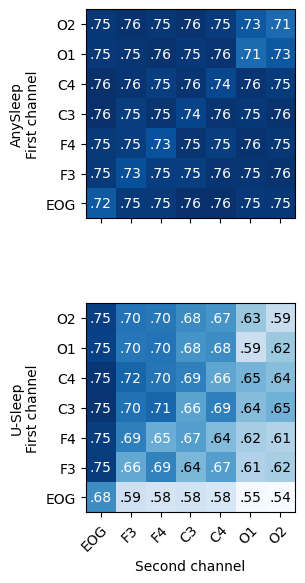

In [9]:
fig, axes = plt.subplots(2, 1, figsize=(2.7, 7), sharey=True, sharex=True)
axes = axes.flatten()

min_color = min(np.min(exp001a_to_plot_means), np.min(exp002a_to_plot_means))
max_color = max(np.max(exp001a_to_plot_means), np.max(exp002a_to_plot_means))

mat_color = np.array(exp002a_to_plot_means)
mat_text = np.array([[f"{e:.2f}"[1:] for e in e_row] for e_row in exp002a_to_plot_means])
plot_matrix(mat_color, mat_text, axes[0], "", req_channels, max_color, min_color)

mat_color = np.array(exp001a_to_plot_means)
mat_text = np.array([[f"{e:.2f}"[1:] for e in e_row] for e_row in exp001a_to_plot_means])
plot_matrix(mat_color, mat_text, axes[1], "", req_channels, max_color, min_color)

axes[1].set_xlabel("Second channel")
axes[0].set_ylabel("AnySleep\nFirst channel")
axes[1].set_ylabel("U-Sleep\nFirst channel")

# clean up tick labels
for ax in axes:
    old_ticklabels = ax.get_xticklabels()
    if len(old_ticklabels) > 0:
        new_ticklabels = [t.get_text().replace("\\d", "") for t in old_ticklabels]
        ax.set_xticklabels(new_ticklabels)

    old_ticklabels = ax.get_yticklabels()
    if len(old_ticklabels) > 0:
        new_ticklabels = [t.get_text().replace("\\d", "") for t in old_ticklabels]
        ax.set_yticklabels(new_ticklabels)

plt.savefig("2_channel_comb_matrix.svg", bbox_inches="tight")
plt.show()

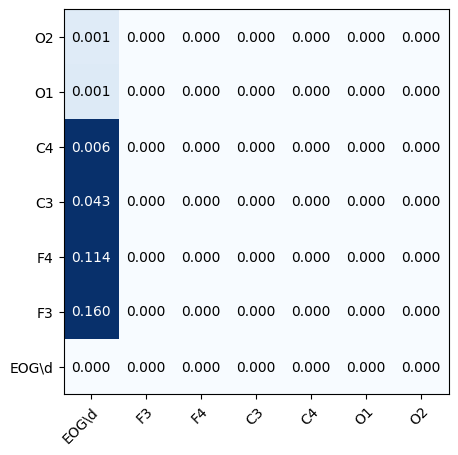

In [10]:
# statistical tests
from scipy import stats

p_val_mat = np.zeros((len(comb_ch_comb_mat_exp001a_new), len(comb_ch_comb_mat_exp001a_new[0])))

for i in range(len(comb_ch_comb_mat_exp001a_new)):
    for j in range(len(comb_ch_comb_mat_exp001a_new[i])):
        usleep = comb_ch_comb_mat_exp001a_new[i][j]
        anysleep = comb_ch_comb_mat_exp002a_new[i][j]

        t_stat, p_val = stats.ttest_ind(usleep, anysleep, equal_var=False, alternative="less")
        p_val_mat[i][j] = p_val

plt.figure(figsize=(5, 5))
mat_text = np.array([[f"{vv:.3f}" for vv in v] for v in p_val_mat])
min_col = np.min(p_val_mat)
max_col = np.max(p_val_mat)
plot_matrix(p_val_mat, mat_text, plt.gca(), "", req_channels, 0.005, 0)
plt.show()